# Final Project
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__  
Throughout this course you’ve engaged with key principles required to develop scalable machine learning analyses for structured and unstructured data. Working in Hadoop Streaming and Spark you’ve learned to translate common machine learning algorithms into Map-Reduce style implementations. You’ve developed the ability to evaluate Machine Learning approaches both in terms of their predictive performance as well as their scalability. For the final project you will demonstrate these skills by solving a machine learning challenge on a new dataset. Your job is to perform Click Through Rate prediction on a large dataset of Criteo advertising data made public as part of a Kaggle competition a few years back. As you perform your analysis, keep in mind that we are not grading you on the final performance of your model or how ‘advanced’ the techniques you use but rather on your ability to explain and develop a scalable machine learning approach to answering a real question.

More about the dataset:
https://www.kaggle.com/c/criteo-display-ad-challenge

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [2]:
import re
import ast
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml.feature import FeatureHasher
from pyspark.sql import SQLContext, Row
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import SparseVector
from pyspark.sql.types import IntegerType
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import FeatureHasher
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [5]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "fproj_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [9]:
# load the data into Spark RDD for convenience of use later (RUN THIS CELL AS IS)
projectRDD = sc.textFile('gs://w261-bucket-pav/notebooks/data/train.txt')

__`REMINDER:`__ If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

# Question 1: Question Formulation 
Introduce the goal of your analysis. What questions will you seek to answer, why do people perform this kind of analysis on this kind of data? Preview what level of performance your model would need to achieve to be practically useful.

# Question 2: Algorithm Explanation
Create your own toy example that matches the dataset provided and use this toy example to explain the math behind the algorithym that you will perform.

# Question 3: EDA & Discussion of Challenges
Determine 2-3 relevant EDA tasks that will help you make decisions about how you implement the algorithm to be scalable. Discuss any challenges that you anticipate based on the EDA you perform

In [9]:
average_CTR = projectRDD.map(lambda x: int(x.split('\t')[0])).mean()

In [10]:
average_CTR

0.25622338372976045

In [8]:
# helper function - RUN THIS CELL AS IS
def extractLabel(line):
    """Mapper to extract labels"""
    label = line[0]
    yield label

def extractTrain(line):
    """ Extracts train data"""
    train = line[1:]
    yield train

In [10]:
projectRDD = projectRDD.map(lambda x: x.split('\t')).cache()
# Split the RDD into train, val and test
trainRDD,valRDD,testRDD=projectRDD.randomSplit([0.8, 0.1, 0.1],2019)

In [14]:
print(f"... held out {valRDD.count()} records for validation, {testRDD.count()} records for test and assigned {trainRDD.count()} for training.")

... held out 4585453 records for validation, 4586499 records for test and assigned 36668665 for training.


In [27]:
trainRDD.take(1)

[['0',
  '2',
  '0',
  '44',
  '1',
  '102',
  '8',
  '2',
  '2',
  '4',
  '1',
  '1',
  '',
  '4',
  '68fd1e64',
  'f0cf0024',
  '6f67f7e5',
  '41274cd7',
  '25c83c98',
  'fe6b92e5',
  '922afcc0',
  '0b153874',
  'a73ee510',
  '2b53e5fb',
  '4f1b46f3',
  '623049e6',
  'd7020589',
  'b28479f6',
  'e6c5b5cd',
  'c92f3b61',
  '07c540c4',
  'b04e4670',
  '21ddcdc9',
  '5840adea',
  '60f6221e',
  '',
  '3a171ecb',
  '43f13e8b',
  'e8b83407',
  '731c3655']]

In [24]:
def parse(element):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    n_elements = len(element)
    fields = np.array(element)
    features,click = fields[1:], fields[0]
    return(features, click)

In [25]:
trainRDDCached = trainRDD.map(parse).cache()

In [83]:
# x_arr = trainRDDCached.take(1)[0][0]
# x_arr[13:]
# FIELDS[13:n_features]

In [34]:
n_features = len(trainRDDCached.take(1)[0][0])
n_features

39

In [50]:
integer_labels = ['I'+str(x) for x in range(1,14)]
print(len(integer_labels))
categor_labels = ['C'+str(x) for x in range(1,27)]
categor_labels.append('click')
FIELDS = integer_labels+categor_labels
print(len(FIELDS))

13
40


In [51]:
# Take sample of 1000 trainRDD
sample = np.array(trainRDDCached.map(lambda x: np.append(x[0], [x[1]]))
                                .takeSample(False, 1000))
sample_df = pd.DataFrame(np.array(sample), columns = FIELDS)

In [52]:
sample_df.head(5)
#sample_df = pd.DataFrame(sample[0][0], columns = FIELDS)

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,click
0,4,150,1,0,95,12,17,0,2,1,...,0b925d96,,,4f7c2d34,,423fab69,64a2febd,,,1
1,7,6,,1,10,1,7,1,1,1,...,74ef3502,,,e9971827,,423fab69,9117a34a,,,0
2,6,4,1,5,2,3,8,5,9,1,...,0705fb3d,,,65e33bf7,ad3062eb,423fab69,2c1b9978,,,1
3,0,0,,1,3797,279,16,3,83,0,...,d39e7a70,,,a6928003,,bcdee96c,8f079aa5,,,0
4,,0,7,,12634,30,4,0,5,,...,6b7fd522,,,6da32e8e,,32c7478e,07e6f0f8,,,0


In [53]:
sample_df.to_pickle("./sample_df.pkl")

In [ ]:
# Load pickled data
sample_df = pd.read_pickle("./sample_df.pkl")

In [54]:
# Replace all empty strings with np.nan
sample_df = sample_df.replace(r'^\s*$', np.nan, regex=True)
sample_df.head(10)

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,click
0,4,150,1,0,95,12,17,0,2,1,...,0b925d96,NaN,NaN,4f7c2d34,NaN,423fab69,64a2febd,NaN,NaN,1
1,7,6,NaN,1,10,1,7,1,1,1,...,74ef3502,NaN,NaN,e9971827,NaN,423fab69,9117a34a,NaN,NaN,0
2,6,4,1,5,2,3,8,5,9,1,...,0705fb3d,NaN,NaN,65e33bf7,ad3062eb,423fab69,2c1b9978,NaN,NaN,1
3,0,0,NaN,1,3797,279,16,3,83,0,...,d39e7a70,NaN,NaN,a6928003,NaN,bcdee96c,8f079aa5,NaN,NaN,0
4,NaN,0,7,NaN,12634,30,4,0,5,NaN,...,6b7fd522,NaN,NaN,6da32e8e,NaN,32c7478e,07e6f0f8,NaN,NaN,0
5,8,11,NaN,2,33,4,38,33,121,2,...,ac2846a6,NaN,NaN,04a420ca,NaN,423fab69,ef218b6e,NaN,NaN,1
6,NaN,3,5,1,299675,NaN,NaN,1,NaN,NaN,...,003d4f4f,NaN,NaN,e587c466,NaN,3a171ecb,3b183c5c,NaN,NaN,0
7,8,1,2,4,53,4,8,4,4,1,...,6fc84bfb,NaN,NaN,4f1aa25f,ad3062eb,423fab69,ded4aac9,NaN,NaN,1
8,NaN,43,87,3,79011,NaN,0,7,3,NaN,...,fb342121,21ddcdc9,5840adea,f6e47def,NaN,c7dc6720,6c1cdd05,ea9a246c,1219b447,0
9,NaN,8,3,2,12175,294,2,2,80,NaN,...,fc16085c,NaN,NaN,c8444cb6,NaN,32c7478e,8940103a,NaN,NaN,0


In [57]:
sample_df[FIELDS[0:13]].isnull().sum()

I1     410
I2       0
I3     227
I4     222
I5      32
I6     198
I7      44
I8       0
I9      44
I10    410
I11     44
I12    777
I13    222
dtype: int64

In [69]:
sample_df[FIELDS[0:13]] = sample_df[FIELDS[0:13]].astype(float)
sample_df.click = sample_df.click.astype(float)

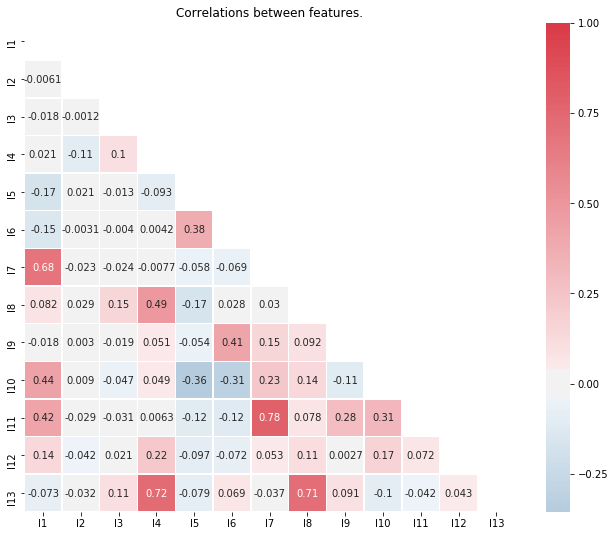

In [59]:
# Correlation between the dependent variables
corr = sample_df[FIELDS[0:13]].corr()
fig,ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

#### I4 & I13, I8 & I13, I7 & I11, I1 & I7 are highly correlated
Since I13 appears twice and correlated with I4 and I8, we can possibly elemenate I13.

In [68]:
#sample_df[FIELDS[0:13]]

In [70]:
# Check correlation with target variable and other integer features
sample_df.drop(FIELDS[13:], axis=1).apply(lambda x: x.corr(sample_df.click))

I1     0.092957
I2     0.017418
I3     0.002890
I4    -0.020240
I5    -0.092118
I6    -0.124801
I7     0.054444
I8    -0.015647
I9    -0.017636
I10    0.153171
I11    0.096868
I12    0.125114
I13   -0.068136
dtype: float64

#### Variables that are least correlated with outcome value are I3, I2, I8, I9

In [72]:
# Convert categorical to one-hot. 
sample_df_onehot = pd.get_dummies(sample_df[FIELDS[13:n_features]])
sample_df_onehot.head(5)

,C1_05db9164,C1_09ca0b81,C1_17f69355,C1_18988050,C1_241546e0,C1_24eda356,C1_255c8173,C1_2d4ea12b,C1_39af2607,C1_3b65d647,...,C26_fa0470cc,C26_fa3124de,C26_fb50b86f,C26_fcd456fa,C26_fda55550,C26_fdf9a32f,C26_fe58998c,C26_ff4e2efb,C26_ff6f8ceb,C26_fffa8e76
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
def n_unique(x):
    """ Counts number of unique values"""
    #If an entry is blank, add them as unique
    total_na = x.isna().sum()
    return x.nunique() + total_na


In [74]:
sample_df[FIELDS[13:n_features]].apply(n_unique,axis=0)

C1      48
C2     198
C3     818
C4     680
C5      23
C6     132
C7     708
C8      42
C9       3
C10    585
C11    578
C12    781
C13    519
C14     15
C15    564
C16    747
C17      9
C18    406
C19    605
C20    497
C21    764
C22    784
C23     12
C24    511
C25    518
C26    794
dtype: int64

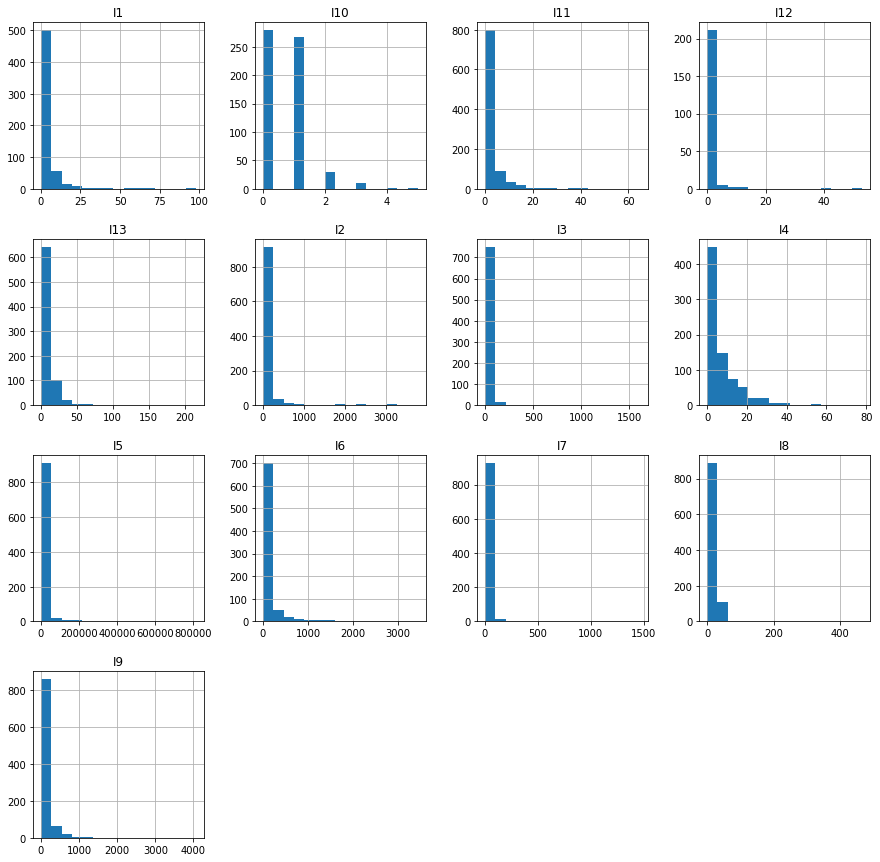

In [75]:
sample_df[FIELDS[0:13]].hist(figsize=(15,15), bins=15)
plt.show()

Variable I5 seem to have major outliers looking at its range

In [99]:
## Distinct values per column on full dataset

def emit_col_val(line):
    features = line[0]
    N = len(features)
    for i in range(13,N):
        yield(i,features[i])

def count_values(line):
    """ Return word count"""
    feature,cat_values = line
    yield (feature,len(cat_values.split()))

catFeatRDD = trainRDDCached.flatMap(emit_col_val)\
                    .distinct()\
                    .reduceByKey(lambda x,y : x+' '+y) \
                    .flatMap(count_values).cache()



In [101]:
catFeat = catFeatRDD.collect()

[(13, 1460),
 (14, 579),
 (15, 8380405),
 (16, 1884751),
 (17, 305),
 (18, 23),
 (19, 12493),
 (20, 633),
 (21, 3),
 (22, 89036),
 (23, 5657),
 (24, 6951577),
 (25, 3194),
 (26, 27),
 (27, 14752),
 (28, 4590483),
 (29, 10),
 (30, 5590),
 (31, 2166),
 (32, 3),
 (33, 5894198),
 (34, 17),
 (35, 15),
 (36, 258633),
 (37, 104),
 (38, 133146)]

In [104]:
for i in range(len(catFeat)):
    print('{}: {}'.format(FIELDS[catFeat[i][0]],catFeat[i][1]))

C1: 1460
C2: 579
C3: 8380405
C4: 1884751
C5: 305
C6: 23
C7: 12493
C8: 633
C9: 3
C10: 89036
C11: 5657
C12: 6951577
C13: 3194
C14: 27
C15: 14752
C16: 4590483
C17: 10
C18: 5590
C19: 2166
C20: 3
C21: 5894198
C22: 17
C23: 15
C24: 258633
C25: 104
C26: 133146


# Question 4: Algorithm Implementation 
Develop a 'homegrown' implementation of the algorithn, apply it to the training dataset and evaluate your results on the test set. 

# Question 5: Application of Course Concepts
Pick 3-5 key course concepts and discuss how your work on this assignment illustrates an understanding of these concepts. 